In [18]:
import os.path
import sys
sys.path.insert(0, os.path.join(os.pardir, 'sparat'))

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

from data_processing.rat import load_rat_items
from data_processing.generate_association_matrix import load_assoc_mat

%matplotlib inline

In [19]:
data = np.load(os.path.join(os.pardir, 'data', 'FfwdConnectionsRat.npz'))
rat_items = load_rat_items(os.path.join(os.pardir, 'data', 'rat', 'example.txt'))

In [20]:
similarities = np.dot(data['vocab_vectors'], data['output'].T)

In [21]:
target_indices = [np.where([y.decode() == x.target for y in data['vocab_keys']])[0][0] for x in rat_items]

In [22]:
selection_intervals = [(0.5, 1.9), (2.5, 3.9), (4.5, 5.9)]
followup_indices = [
    np.argsort(np.mean(similarities[:, np.logical_and(data['trange'] >= l, data['trange'] < u)], axis=1))[::-1][:2]
    for (l, u) in selection_intervals
]
followup_indices = [x if x != target_indices[i] else y for i, (x, y) in enumerate(followup_indices)]

In [23]:
condlist = [data['trange'] < 2. * i for i in range(1, len(target_indices) + 1)]
target_sim = np.select(
    condlist,
    [similarities[target_indices[i]] for i in range(len(target_indices))])
followup_sim = np.select(
    condlist,
    [similarities[followup_indices[i]] for i in range(len(target_indices))])

In [48]:
assoc, i2w, w2i = load_assoc_mat(os.path.join(
    os.pardir, 'data', 'associationmatrices'), 'freeassoc_asymmetric')
rat_items = load_rat_items(os.path.join(os.pardir, 'data', 'rat', 'example.txt'))
ground_truth = np.array([np.sum([assoc[w2i[c]] for c in item.cues], axis=0) / 3. for item in rat_items])
target_ground_truth = np.select(condlist, [ground_truth[i, target_indices[i]] for i in range(len(rat_items))])
followup_ground_truth = np.select(condlist, [ground_truth[i, followup_indices[i]] for i in range(len(rat_items))])

In [49]:
import matplotlib
import numpy
import scipy
import scipy.ndimage

def add_spikes(ax, time, data, sample_by_variance=None,
                     sample=None, sample_filter_width=20,
                     cluster=False, cluster_filter_width=2,
                     merge=None, contrast_scale=1.0, yticks=None,
                     sample_index=None, cluster_index=None):

    if sample_index:
        data = data[:, sample_index]    
    elif sample_by_variance is not None and sample_by_variance<len(data.T):
        dd=scipy.ndimage.gaussian_filter1d(data.astype(float).T,sample_filter_width,axis=1)
        vard=numpy.var(dd,axis=1)

        threshold=sorted(vard)[-sample_by_variance]                        
        index=[k for k,v in enumerate(vard) if v>=threshold]
        data=data[:,index]

    if sample is not None and sample<len(data.T):    
        stepsize=float(len(data.T))/sample
        data2=[]
        for k in range(sample):
            sub=data[:,int(k*stepsize):int((k+1)*stepsize)]
            count=numpy.sum(sub,axis=0)
            maxv=max(count)
            for i,v in enumerate(count):
                if v==maxv: 
                    data2.append(sub[:,i])
                    break
        data=numpy.array(data2).T    

    if cluster_index:
        data = data[:, cluster_index]    
    elif cluster:
        dd=scipy.ndimage.gaussian_filter1d(data.astype(float).T,cluster_filter_width,axis=1)
        z=scipy.cluster.hierarchy.linkage(dd)
        tree=scipy.cluster.hierarchy.to_tree(z)
        order=tree.pre_order()
        data=data[:,order]
    if merge is not None and merge<len(data.T):    
        stepsize=float(len(data.T))/merge
        data2=[]
        for k in range(merge):
            v=numpy.sum(data[:,int(k*stepsize):int((k+1)*stepsize)],axis=1)
            data2.append(v)
        data=numpy.array(data2).T    

                  
    imgplt=ax.imshow(data.T,aspect='auto',cmap=matplotlib.cm.gray_r,interpolation='nearest',extent=(time[0],time[-1],0,len(data.T)))
    imgplt.set_clim(0.0,numpy.max(data)*contrast_scale)

In [50]:
sns.set('paper', 'ticks')

column_width_pt = 243.91125
pt2inch = 1. / 72.27
column_width_inch = pt2inch * column_width_pt

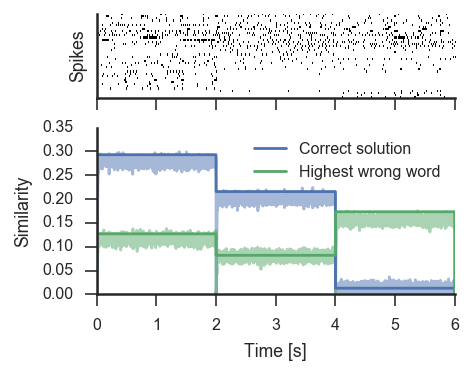

In [56]:
%matplotlib inline
import matplotlib.gridspec as gridspec

sns.set_style('ticks')
fig = plt.figure(figsize=(column_width_inch, .8 * column_width_inch))
gs = gridspec.GridSpec(2, 1, height_ratios=(1, 2))

ax = fig.add_subplot(gs[0])
add_spikes(ax, data['trange'], data['spikes'], sample_by_variance=40, sample_filter_width=200, cluster=True)
ax.label_outer()
ax.set_yticks([])
ax.set_ylabel("Spikes")
sns.despine(ax=ax)

ax = fig.add_subplot(gs[1], sharex=ax)
colors = sns.color_palette(n_colors=2)
ax.plot(data['trange'], target_sim, c=colors[0], alpha=0.5)
ax.plot(data['trange'], followup_sim, c=colors[1], alpha=0.5)
ax.plot(data['trange'], target_ground_truth, c=colors[0], label="Correct solution")
ax.plot(data['trange'], followup_ground_truth, c=colors[1], label="Highest wrong word")
ax.set_ylim(bottom=0)
ax.label_outer()
ax.set_xlabel("Time [s]")
ax.set_ylabel("Similarity")
ax.set_ylim(0, 0.35)
ax.legend(loc='best')
sns.despine(ax=ax)

plt.tight_layout()

In [57]:
fig.savefig(os.path.join(os.pardir, 'txt', 'cogsci-paper', 'figures', 'spikes.pdf'), dpi=600)